In [3]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
datos = pd.read_excel("02.Generación Pearson Photovoltaic.xlsx")
datos["Generacion_prev_hour"] = datos["Generación"].shift(1)
datos = datos.dropna(how="any", axis= 0)
datos.index = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d %H:%M:%s')
datos = datos.drop(columns='Fecha', axis=1)
datos = datos[(datos['Hora']>=6) & (datos['Hora']<=19)]
datos.head(4)

,Generación,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour
Fecha,,,,,,,,,
2022-09-01 06:00:00,0.000000,0.0,18,6,16,54,3,89,0.000000
2022-09-01 07:00:00,6.584959,0.0,18,7,17,70,4,95,0.000000
2022-09-01 08:00:00,560.422022,0.0,18,8,18,72,3,100,6.584959
2022-09-01 09:00:00,7720.582326,1.0,18,9,18,81,4,100,560.422022


División de datos en Soleado, nublado y lluvioso

In [6]:
datosX = datos[['Índice UV', 'Temperatura', 'Hora', 'DPT',
       'Cobertura Nubes', 'Condición Cielo', 'Humedad Relativa',
       'Generacion_prev_hour']]

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(datosX)

In [8]:
from sklearn.mixture import GaussianMixture
# Definir el número de clusters (puedes ajustar el valor de n_components)
n_clusters = 3  # Puedes probar con otros valores
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
clusters = gmm.fit_predict(X_scaled)

In [9]:
datos['Cluster'] = clusters
datos

,Generación,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour,Cluster
Fecha,,,,,,,,,,
2022-09-01 06:00:00,0.000000,0.0,18,6,16,54,3,89,0.000000,2
2022-09-01 07:00:00,6.584959,0.0,18,7,17,70,4,95,0.000000,2
2022-09-01 08:00:00,560.422022,0.0,18,8,18,72,3,100,6.584959,2
2022-09-01 09:00:00,7720.582326,1.0,18,9,18,81,4,100,560.422022,2
2022-09-01 10:00:00,9433.109309,2.0,19,10,18,89,4,93,7720.582326,2
...,...,...,...,...,...,...,...,...,...,...
2024-10-02 15:00:00,25562.000000,5.0,25,15,8,43,3,34,25399.000000,1
2024-10-02 16:00:00,25386.000000,4.0,26,16,8,25,2,31,25562.000000,0
2024-10-02 17:00:00,22872.000000,2.0,26,17,8,18,1,32,25386.000000,0


In [10]:
print(datos['Cluster'].value_counts())
# Calcular estadísticas de cada cluster
cluster_means = datos.groupby('Cluster').mean()
cluster_means

Cluster
0    4170
1    3240
2    3230
Name: count, dtype: int64


,Generación,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour
Cluster,,,,,,,,,
0,21415.756950,5.717770,24.942926,14.378657,8.026619,16.220384,1.315588,34.763309,22608.303011
1,18699.424944,2.883673,23.033642,14.749383,9.027160,81.955864,3.727160,43.929630,20213.767521
2,6637.023839,0.894118,13.698762,7.818266,10.952632,59.483282,3.046130,84.386068,2425.852900


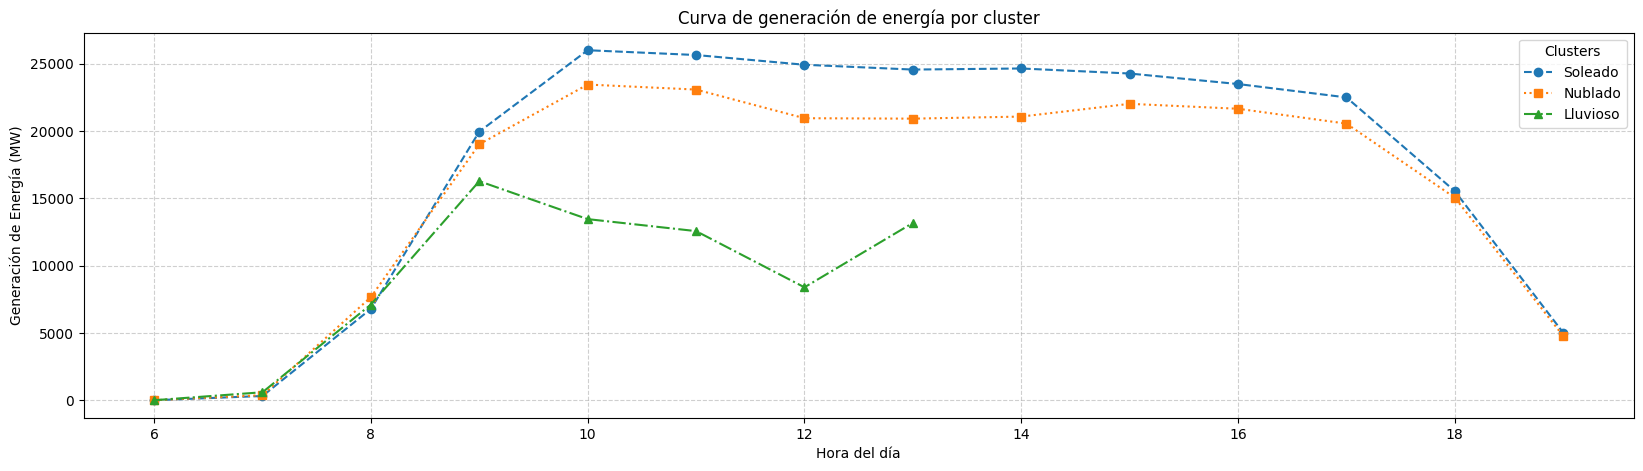

In [11]:
import matplotlib.pyplot as plt
df_grouped = datos.groupby(['Hora', 'Cluster'])['Generación'].mean().reset_index()

plt.figure(figsize=(20,5))

clusters = df_grouped['Cluster'].unique()

# Definir estilos para cada cluster
line_styles = ['dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1)), (0, (5, 1))]
markers = ['o', 's', '^', 'D', 'x']

# Dibujar una línea para cada cluster
for i, cluster in enumerate(clusters):
    if cluster == 0:
        label = 'Soleado'
    if cluster == 1:
        label = 'Nublado'
    if cluster == 2:
        label = 'Lluvioso'
    subset = df_grouped[df_grouped['Cluster'] == cluster]
    plt.plot(subset['Hora'], subset['Generación'], 
             linestyle=line_styles[i % len(line_styles)], 
             marker=markers[i % len(markers)], 
             label=label)

# Configuración de la gráfica
plt.xlabel("Hora del día")
plt.ylabel("Generación de Energía (MW)")
plt.title("Curva de generación de energía por cluster")
plt.legend(title="Clusters")
plt.grid(True, linestyle="--", alpha=0.6)

# Mostrar la gráfica
plt.show()

Cluster 0: Soleado, Cluster 1: Nublado, Cluster 2: Lluvioso

Entrenamiento 70-30

In [13]:
import numpy as np
def datos_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [14]:
WINDOW_SIZE = 10
X_Soleado, y_Soleado = datos_to_X_y(datos[datos['Cluster']==0].drop(columns='Cluster', axis=1), WINDOW_SIZE)
X_Nublado, y_Nublado = datos_to_X_y(datos[datos['Cluster']==1].drop(columns='Cluster', axis=1), WINDOW_SIZE)
X_Lluvioso, y_Lluvioso = datos_to_X_y(datos[datos['Cluster']==2].drop(columns='Cluster', axis=1), WINDOW_SIZE)
X_Soleado.shape, y_Soleado.shape, X_Nublado.shape, y_Nublado.shape, X_Lluvioso.shape, y_Lluvioso.shape

((4160, 10, 9), (4160,), (3230, 10, 9), (3230,), (3220, 10, 9), (3220,))

In [15]:
num_datos_Soleado = X_Soleado.shape[0]
train_Soleado = int(round(num_datos_Soleado * 0.7,0))
val_Soleado = int(train_Soleado + round((num_datos_Soleado - train_Soleado) / 2, 0))

num_datos_Nublado = X_Nublado.shape[0]
train_Nublado = int(round(num_datos_Nublado * 0.7,0))
val_Nublado = int(train_Nublado + round((num_datos_Nublado - train_Nublado) / 2, 0))

num_datos_Lluvioso = X_Lluvioso.shape[0]
train_Lluvioso = int(round(num_datos_Lluvioso * 0.7,0))
val_Lluvioso = int(train_Lluvioso + round((num_datos_Lluvioso - train_Lluvioso) / 2, 0))

num_datos_Soleado, train_Soleado, val_Soleado, num_datos_Nublado, train_Nublado, val_Nublado, num_datos_Lluvioso, train_Lluvioso, val_Lluvioso

(4160, 2912, 3536, 3230, 2261, 2745, 3220, 2254, 2737)

In [16]:
X_Soleado_train, y_Soleado_train = X_Soleado[:train_Soleado], y_Soleado[:train_Soleado]
X_Soleado_test, y_Soleado_test = X_Soleado[train_Soleado:], y_Soleado[train_Soleado:]
X_Soleado_train.shape, y_Soleado_train.shape, X_Soleado_test.shape, y_Soleado_test.shape

((2912, 10, 9), (2912,), (1248, 10, 9), (1248,))

In [17]:
X_Nublado_train, y_Nublado_train = X_Nublado[:train_Nublado], y_Nublado[:train_Nublado]
X_Nublado_test, y_Nublado_test = X_Nublado[train_Nublado:], y_Nublado[train_Nublado:]
X_Nublado_train.shape, y_Nublado_train.shape, X_Nublado_test.shape, y_Nublado_test.shape

((2261, 10, 9), (2261,), (969, 10, 9), (969,))

In [18]:
X_Lluvioso_train, y_Lluvioso_train = X_Lluvioso[:train_Lluvioso], y_Lluvioso[:train_Lluvioso]
X_Lluvioso_test, y_Lluvioso_test = X_Lluvioso[train_Lluvioso:], y_Lluvioso[train_Lluvioso:]
X_Lluvioso_train.shape, y_Lluvioso_train.shape, X_Lluvioso_test.shape, y_Lluvioso_test.shape

((2254, 10, 9), (2254,), (966, 10, 9), (966,))

Definición del modelo

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [45]:
inputs = Input(shape=(WINDOW_SIZE, 9))

# Primera capa CNN
x = Conv1D(filters=64, kernel_size=4, padding='same', activation='relu')(inputs)
x = MaxPooling1D(pool_size=3)(x)

# Segunda capa CNN
x = Conv1D(filters=128, kernel_size=4, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)

# Capa BiGRU
x = Bidirectional(GRU(128, return_sequences=True))(x)

# Atención: se define de forma explícita
attention = MultiHeadAttention(num_heads=4, key_dim=128)(x, x)

# Aplanar y agregar Dropout
x = Flatten()(attention)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)  # Nueva capa intermedia
x = Dense(32, activation="relu")(x)  # Otra capa intermedia

# Capa de salida
outputs = Dense(1, activation="relu")(x)

# Definir el modelo
model_Soleado = Model(inputs=inputs, outputs=outputs)

# Resumen del modelo
model_Soleado.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 10, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 10, 64)    │      2,368 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 3, 64)     │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 3, 128)    │     32,896 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 1, 128)    │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 1, 256)    │    198,144 │ max_pooling1d_7[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 256)    │    526,080 │ bidirectional_3[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 256)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         33 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 778,049 (2.97 MB)

 Trainable params: 778,049 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
cp = ModelCheckpoint('Photovoltaic_model_Soleado.keras', save_best_only=True)
model_Soleado.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error", metrics=['mae'])

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_Soleado_train = scaler_X.fit_transform(X_Soleado_train.reshape(-1, X_Soleado_train.shape[-1])).reshape(X_Soleado_train.shape)
X_Soleado_test = scaler_X.transform(X_Soleado_test.reshape(-1, X_Soleado_test.shape[-1])).reshape(X_Soleado_test.shape)

y_Soleado_train = scaler_y.fit_transform(y_Soleado_train.reshape(-1, 1)).reshape(-1)
y_Soleado_test = scaler_y.transform(y_Soleado_test.reshape(-1, 1)).reshape(-1)


In [48]:
X_Soleado_train.shape, y_Soleado_train.shape, X_Soleado_test.shape, y_Soleado_test.shape

((2912, 10, 9), (2912,), (1248, 10, 9), (1248,))

In [49]:
# Entrenamiento del modelo
history = model_Soleado.fit(
    X_Soleado_train, y_Soleado_train,  # Datos de entrenamiento
    validation_data=(X_Soleado_test, y_Soleado_test),  # Datos de validación
    epochs=200,  # Número de épocas
    batch_size=32,  # Tamaño del batch
    callbacks=[cp]
)


Epoch 1/200


91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - loss: 0.1376 - mae: 0.2893 - val_loss: 36.9388 - val_mae: 6.0707
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.0497 - mae: 0.1706 - val_loss: 44.5219 - val_mae: 6.6637
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.0472 - mae: 0.1671 - val_loss: 19.9780 - val_mae: 4.4586
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 0.0392 - mae: 0.1459 - val_loss: 23.6525 - val_mae: 4.8478
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.0314 - mae: 0.1280 - val_loss: 17.3027 - val_mae: 4.1453
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.0283 - mae: 0.1201 - val_loss: 14.4295 - val_mae: 3.7756
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.0287 - mae: 0.1182 - val_loss: 7.4996 - val_mae: 2.7109
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - loss: 0.0297 - mae: 0.1221 - val_loss: 7.3969 - val_mae: 2.6887
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/ste

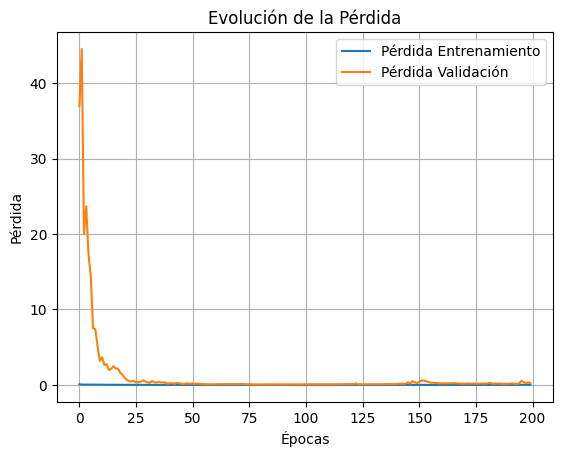

In [50]:
import matplotlib.pyplot as plt

# Extraer la pérdida del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear la gráfica
plt.plot(train_loss, label='Pérdida Entrenamiento')
plt.plot(val_loss, label='Pérdida Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
from sklearn.metrics import mean_absolute_percentage_error as mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error as mean_absolute_error
from sklearn.metrics import mean_squared_error as mean_squared_error
from sklearn.metrics import r2_score as r2_score
def plot_predictions1(model, X, y, scaler_y, start=0, end=100):
    predictions = model.predict(X).flatten()
    y = y.flatten()
    predictions_original = scaler_y.inverse_transform(predictions.reshape(-1, 1)).reshape(-1)
    predictions_original = np.clip(predictions_original, 0, 30000)
    y_original = scaler_y.inverse_transform(y.reshape(-1, 1)).reshape(-1)
    df = pd.DataFrame(data={'Predictions': predictions_original, 'Actuals': y_original})
    plt.figure(figsize=(20, 5))
    print(f"MAE: {mean_absolute_error(y_original, predictions_original):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_original, predictions_original)):.4f}")
    print(f"R²: {r2_score(y_original, predictions_original):.4f}")
    plt.plot(y_original, label='Valor Real', color='blue')
    plt.plot(predictions_original, label='Predicción', color='red', linestyle='dashed')
    plt.xlabel("Hora")
    plt.ylabel("Valor")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    return df

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
MAE: 6660.9421
RMSE: 9668.5648
R²: -0.9034


,Predictions,Actuals
0,30000.0,19133.0
1,30000.0,18815.0
2,30000.0,18790.0
3,30000.0,19205.0
4,30000.0,13983.0
...,...,...
1243,30000.0,1407.0
1244,30000.0,25386.0
1245,30000.0,22872.0
1246,30000.0,15825.0


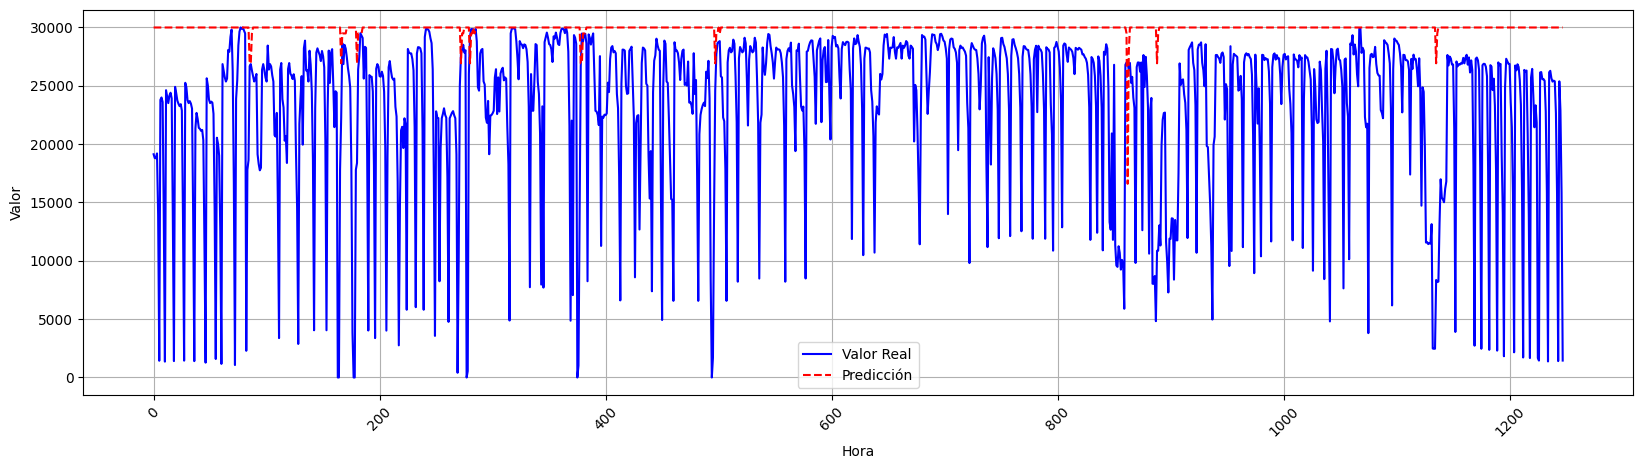

In [52]:
plot_predictions1(model_Soleado, X_Soleado_test, y_Soleado_test, scaler_y)